In [1]:
import numpy as np
import pandas as pd
import h5py
import math
import itertools
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa

# to work with python3.10, install this directly from github
# pip install git+https://github.com/danilobellini/audiolazy.git
from audiolazy import str2midi, midi2str

from midiutil import MIDIFile
import pygame
import pyaudio # requires `brew install portaudio`

# import oscillators as osc # local file, oscillators.py
import oscillators as osc

pygame 2.1.2 (SDL 2.0.18, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Generating our own synth audio waveforms

Using generators and iterators we can generate infinite streams of integers which can be fed to some output like a speaker or a file.  

Without these features the memory requirements would be very high.

To overly simplify a synth, it consists of components that generate the sound such as oscillators, and components that shape the sound such as envelopes and LFOs (Low Frequency Oscillators), and maybe even components that add effects to the sounds such as a vibrato, or a tremolo. 

Reference:
* [Making A Synth With Python — Oscillators](https://python.plainenglish.io/making-a-synth-with-python-oscillators-2cb8e68e9c3b)

In [13]:
# Simple example: Using a python generator object to generate audio samples
def get_sin_oscillator(freq, amp=1, phase=0, sample_rate=44100):
    # returns a generator
    phase = (phase / 360) * 2 * math.pi
    increment = (2 * math.pi * freq)/ sample_rate
    return (math.sin(phase + v) * amp for v in itertools.count(start=0, step=increment))

osc = get_sin_oscillator(freq=1, sample_rate=512)
samples = [next(osc) for i in range(512)]

### A dynamic class for oscillators

It would be much nicer if we could adjust these three parameters on the fly i.e. without 

having to create a new generator everytime an adjustment is made.

This would allow us to hook oscillators up with other oscillators to obtain all kinds of fun sounds.

This covers a lot of what happens in synthesizers, oscillators oscillating oscillators; wub-wub!

So what we'll do now is define a class `Oscillator` which allows these parameters to be adjusted on-the-fly.

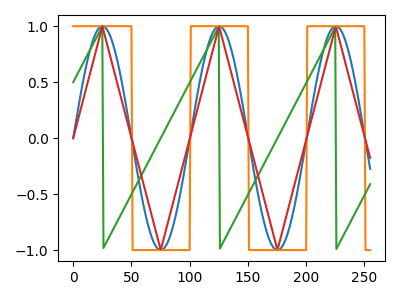

In [15]:
# for debugging, re-import the stuff in oscillators.py every time this cell is run
import oscillators as osc
from importlib import reload 
reload(osc) 

# show a few different types of oscillators.
%matplotlib widget

# these are defined for all oscillators, I just list them here for reference
default_kwargs = {'freq':440, 'phase':0, 'amp':1, 'sample_rate':44_100, 'wave_range':(-1, 1)}

osc_sin = osc.SineOscillator(); iter(osc_sin) # have to call iter once before we can call next()
osc_squ = osc.SquareOscillator(threshold=0); iter(osc_squ) # additional kwarg
osc_saw = osc.SawtoothOscillator(); iter(osc_saw)
osc_tri = osc.TriangleOscillator(); iter(osc_tri)

ns = 256 
ts_samples = np.arange(ns)
sin_samples = [next(osc_sin) for i in range(ns)]
squ_samples = [next(osc_squ) for i in range(ns)]
saw_samples = [next(osc_saw) for i in range(ns)]
tri_samples = [next(osc_tri) for i in range(ns)]

fig = plt.figure(figsize=(4,3))
fig.canvas.header_visible = False
plt.plot(ts_samples, sin_samples)
plt.plot(ts_samples, squ_samples)
plt.plot(ts_samples, saw_samples)
plt.plot(ts_samples, tri_samples)
plt.tight_layout()
plt.show()

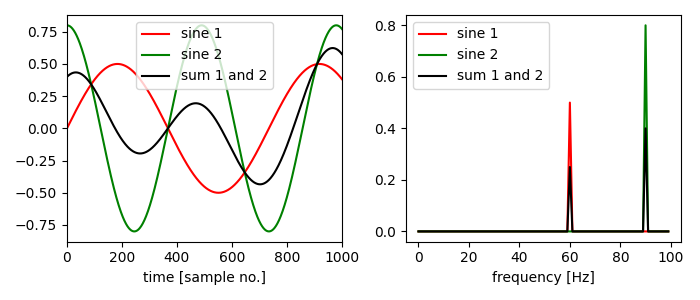

In [16]:
# add two waveforms with different parameters, output to file, and play it back.

# for debugging, re-import the stuff in oscillators.py every time this cell is run
import oscillators as osc
from importlib import reload 
reload(osc) 

%matplotlib widget
fig, p = plt.subplots(1, 2, figsize=(7, 3))
fig.canvas.header_visible = False

# by default, return 1 second of samples at the given sample rate (e.g. 44100)
osc_sine1 = osc.SineOscillator(freq=60, amp=0.5, phase=0)
iter(osc_sine1) # have to call iter once to set _i ... weird.  maybe Alan had a reason
yv_sine1 = np.asarray(osc.get_val(osc_sine1))

osc_sine2 = osc.SineOscillator(freq=90, amp=0.8, phase=90)
iter(osc_sine2)
yv_sine2 = np.asarray(osc.get_val(osc_sine2))

osc_sine3 = osc.WaveAdder(osc_sine1, osc_sine2)
iter(osc_sine3)
yv_sine3 = np.asarray(osc.get_val(osc_sine3))

p[0].plot(yv_sine1, '-r', label='sine 1')
p[0].plot(yv_sine2, '-g', label='sine 2')
p[0].plot(yv_sine3, '-k', label='sum 1 and 2')
p[0].set_xlabel('time [sample no.]')

p[0].set_xlim(0, 1000)
p[0].legend()

# get fft info
fslice = slice(0, 100)
xs1, ys1 = osc.fplot_xy(yv_sine1, fslice)
xs2, ys2 = osc.fplot_xy(yv_sine2, fslice)
xs3, ys3 = osc.fplot_xy(yv_sine3, fslice)

p[1].plot(xs1, ys1, 'r', label='sine 1')
p[1].plot(xs2, ys2, 'g', label='sine 2')
p[1].plot(xs3, ys3, 'k', label='sum 1 and 2')
p[1].set_xlabel('frequency [Hz]')

p[1].legend()
plt.tight_layout()
plt.show()

### Modulating oscillators

* **Generator** — anything that will generate a signal (series of numbers) for the purpose of playback, like an oscillator.

* **Modulator** — anything that modulates the signal of a generator by generating its own sequence of notes, it maybe a generator itself.

* **Modifier** — anything that modifies the signal of a generator but doesn’t generate its own signal to do so.

There are also combinations such as modulated modulators which may be used on generators, and modulated generators ...

We first examine an **envelope**, which is a type of modulator that changes the oscillator parameters (such as amplitude).

Reference:
* [Alan's `synth` code on github](https://github.com/18alantom/synth)

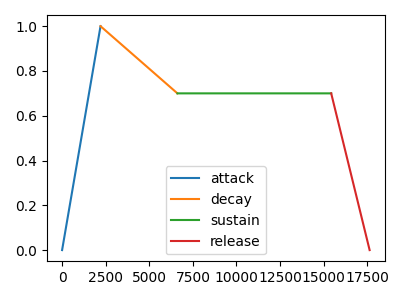

In [17]:
# Simple example of an ADSR envelope without the class.
# The parameters are defined in terms of a duration (sec) times a sampling rate (samples / sec).

smrate = 44100 # Hz (samples / sec)
attack_length = int(0.05 * smrate)
decay_length = int(0.1 * smrate)
sustain_level = 0.7
sustain_length = int(0.2 * smrate)
release_length = int(0.05 * smrate)

attack = np.linspace(0, 1, attack_length)
decay = np.linspace(1, sustain_level, decay_length)
sustain = np.full((sustain_length, ), sustain_level)
release = np.linspace(sustain_level, 0, release_length)

%matplotlib widget
fig = plt.figure(figsize=(4,3))
fig.canvas.header_visible = False

ts_attack = np.arange(len(attack))
plt.plot(ts_attack, attack, label='attack')

ts_decay = np.arange(len(decay)) + ts_attack[-1]
plt.plot(ts_decay, decay, label='decay')

ts_sustain = np.arange(len(sustain)) + ts_decay[-1]
plt.plot(ts_sustain, sustain, label='sustain')

ts_release = np.arange(len(release)) + ts_sustain[-1]
plt.plot(ts_release, release, label='release')

plt.legend()
plt.tight_layout()
plt.show()

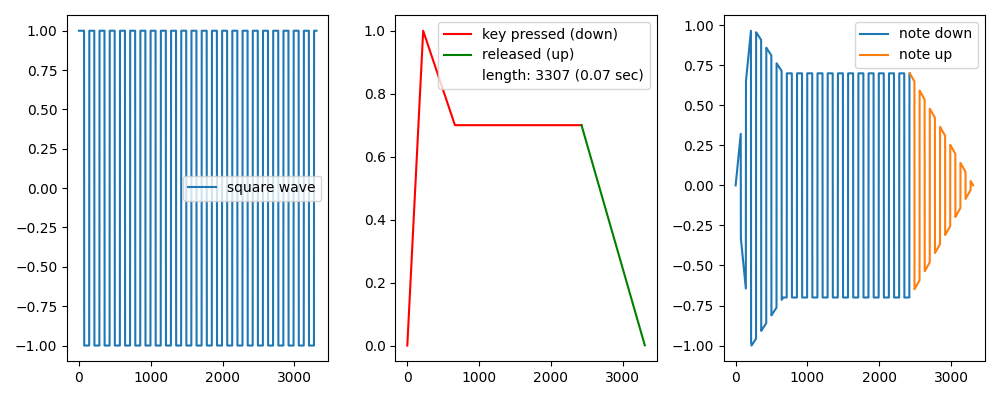

In [28]:
# Example of an ADSR envelope with the class, modulating a square wave.
# 1 second is too long to plot a square wave at 44100 samples/sec, so use a very short envelope.

# for debugging, re-import the stuff in oscillators.py every time this cell is run
from importlib import reload 
reload(osc) 

sr = 44100

# square wave
osc_squ = osc.SquareOscillator(freq=310, threshold=0)
iter(osc_squ)
osc_vals = np.asarray(osc.get_val(osc_squ)) # default 1 second of samples (44,100)

# envelope (ADSREnvelope class)
env_vals, ix_down, ix_up = osc.get_adsr(a=0.005, d=0.01, sl=0.7, r=0.02, sd=0.04, sample_rate=44_100)
env_vals = np.array(env_vals)
xdn = np.arange(ix_down)
xup = np.arange(ix_down, ix_down + ix_up)
env_time = len(env_vals) / sr
ix_env = len(env_vals)

# combined
mod_vals = osc_vals[:ix_env] * env_vals[:ix_env]

%matplotlib widget
fig, p = plt.subplots(1, 3, figsize=(10,4))
fig.canvas.header_visible = False

p[0].plot(osc_vals[:ix_env], label='square wave')
p[0].legend()

p[1].plot(xdn, env_vals[:ix_down], c='r', label='key pressed (down)')
p[1].plot(xup, env_vals[ix_down:], c='g', label='released (up)')
p[1].plot(np.nan, c='w', label=f'length: {len(env_vals)} ({env_time:.2f} sec)')
p[1].legend(loc=1, fontsize=10)

p[2].plot(xdn, mod_vals[:ix_down], label='note down')
p[2].plot(xup, mod_vals[ix_down:], label='note up')
p[2].legend()

plt.tight_layout()
plt.show()


In [96]:
# Repeat the files generated in Alan's Oscillators example to hear their sounds 
# and demonstrate how to write & playback these waveforms.
from importlib import reload 
reload(osc) 

duration = 3

# OT Vibes
vibes = osc.WaveAdder(
    osc.SquareOscillator(27.5, amp=0.1),
    osc.TriangleOscillator(55, amp=0.5),
    osc.SineOscillator(115),
    osc.SquareOscillator(220, amp=0.1),
    osc.SineOscillator(440, amp=0.3),
    osc.TriangleOscillator(880, amp=0.05),
) # NOTE - no need to call iter() for some reason on the WaveAdder
wave = osc.get_val(iter(vibes), sr * duration)
osc.wave_to_file(wave, fname='ot_vibes.wav')

# Amin_6
osc1 = osc.WaveAdder(
    osc.SineOscillator(librosa.note_to_hz('A2')),
    osc.SineOscillator(librosa.note_to_hz('A2')+3),
    osc.TriangleOscillator(librosa.note_to_hz('A4'), amp=0.6),
    osc.TriangleOscillator(librosa.note_to_hz('E5'), amp=0.8),
)

wave1 = osc.get_val(iter(osc1), sr * duration)
osc2 = osc.WaveAdder(
    osc.SineOscillator(librosa.note_to_hz('A2')),
    osc.SineOscillator(librosa.note_to_hz('A2')+3),
    osc.TriangleOscillator(librosa.note_to_hz('C5'), amp=0.8),
    osc.TriangleOscillator(librosa.note_to_hz('F5'), amp=0.6),
)
wave2 = osc.get_val(iter(osc2), sr * duration)
osc.wave_to_file(wave1, wave2, fname='a_min6.wav', amp=1.1) # above 1 causes clipping, but maybe you want that?

In [97]:
# play the sounds back (makes a little widget)
# ipd.Audio('ot_vibes.wav')
ipd.Audio('a_min6.wav')

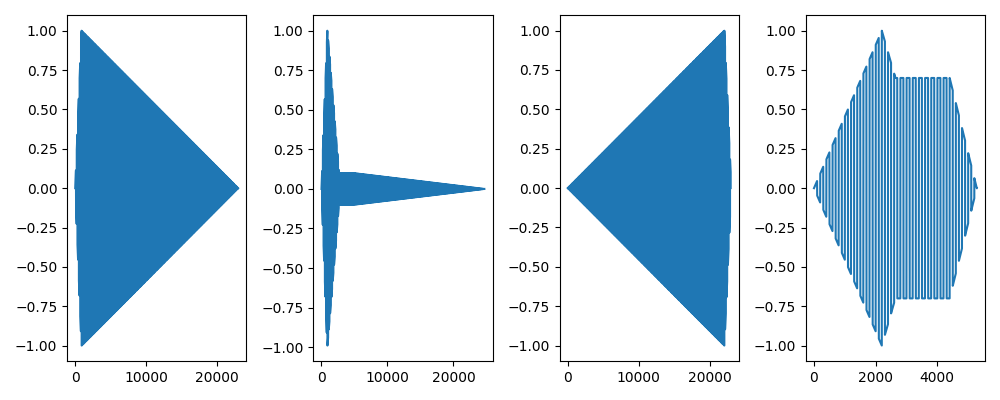

In [117]:
from importlib import reload 
reload(osc) 

%matplotlib widget 
fig, p = plt.subplots(1, 4, figsize=(10,4))
fig.canvas.header_visible = False

osc_saw = osc.SquareOscillator(librosa.note_to_hz('A3'))
wave1 = osc.get_adsr_mod(a=0.02, d=0.5, sl=0, sd=0, r=0, Osc=osc_saw)
p[0].plot(wave1, label='dropper')

wave2 = osc.get_adsr_mod(a=0.02, d=0.04, sl=0.1, sd=0.05, r=0.45, Osc=osc_saw)
p[1].plot(wave2, label='transient')

wave3 = osc.get_adsr_mod(a=0.5, d=0.02, sl=0.1, sd=0, r=0, Osc=osc_saw)
p[2].plot(wave3, label='riser')

wave4 = osc.get_adsr_mod(a=0.05, d=0.01, sl=0.7, r=0.02, sd=0.04, Osc=osc_saw)
p[3].plot(wave4, label='normie')

osc.wave_to_file(wave1, fname='dropper.wav', amp=3)
osc.wave_to_file(wave2, fname='transient.wav', amp=5)
osc.wave_to_file(wave3, fname='riser.wav', amp=3)
osc.wave_to_file(wave1, wave3, fname='twowaves.wav', amp=3)
osc.wave_to_file(wave4, fname='normie.wav', amp=1)

plt.tight_layout()
plt.show()

In [122]:
# play the sounds back (makes a little widget)
# ipd.Audio('dropper.wav')
# ipd.Audio('transient.wav')
# ipd.Audio('riser.wav')
# ipd.Audio('twowaves.wav')
ipd.Audio('normie.wav')

## Live Visualization

It would be neat to show some plots while playing back the MIDI file:

* Plot a log-histogram and view the counts versus time

* Plot realtime FFT

I really like the toolkit for fast data visualization [PyQtGraph](https://www.pyqtgraph.org/), which is built on PyQt5.  

This also seems good -- [Realtime_PyAudio_FFT](https://github.com/aiXander/Realtime_PyAudio_FFT).

TODO: Figure out how embed these applications in the jupyter notebook, they usually have to pop up new windows.

In [3]:
%gui qt5
from PyQt5.Qt import QApplication

# start qt event loop
_instance = QApplication.instance()
if not _instance:
    _instance = QApplication([])
app = _instance

import pyqtgraph as pg

# create and and set layout
view = pg.GraphicsView()   
view.setWindowTitle('Your title')
layout = pg.GraphicsLayout()
view.setCentralItem(layout)
view.show()

# Set white graph
pg.setConfigOptions(antialias=True)
pg.setConfigOption('background', 'w')
pg.setConfigOption('foreground', 'k')

# add subplots
p0 = layout.addPlot(0,0)
p0.addLegend()
p0.plot([1,2,3,4,5], pen='b', name='p0')

p1 = layout.addPlot(1,0)
p1.addLegend()
p1.plot([2,2,2,2,], pen='r', name='p1')

p2 = layout.addPlot(1,0)
p2.addLegend(offset=(50, 0))
p2.plot([-1,0,1,1,], pen='g', name='p1.1')
p2.hideAxis('left')
p2.showAxis('right')

QGridLayoutEngine::addItem: Cell (1, 0) already taken


In [4]:
# The above creates an un-closeable app window sometimes
view.close()
app.quit()